In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.metrics import plot_confusion_matrix, classification_report                
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTENC
# from sklearn.impute import SimpleImputer

In [84]:
testv = pd.read_csv('../data/test_vals.csv')
trainl = pd.read_csv('../data/training_labels.csv')
trainv = pd.read_csv('../data/training_vals.csv')

In [85]:
trainl.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [86]:
idequality = (trainl['id'] == trainv['id'] )

In [87]:
data = pd.merge(trainv, trainl) #merging into one dataset


In [88]:
print(set(data.columns).difference(set(trainv.columns))) # a sort of check to see if merge worked

{'status_group'}


In [89]:
# testohe = OneHotEncoder()
# dummy1 = pd.get_dummies(data['scheme_name'].dropna())
# dummy2 = pd.get_dummies(data['status_group'].dropna())
# testtree = DecisionTreeClassifier(max_depth=3)
# testtree.fit(dummy1, dummy2 )/
# testtree.score(data['scheme_name'], data['status_group'])

In [90]:
# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler),
#     ('ohe', OneHotEncoder)
#     ('polynom', PolynomialFeatures)
# ])

In [91]:
data['waterpoint_type_group'].unique(), data['waterpoint_type'].unique()

(array(['communal standpipe', 'hand pump', 'other', 'improved spring',
        'cattle trough', 'dam'], dtype=object),
 array(['communal standpipe', 'communal standpipe multiple', 'hand pump',
        'other', 'improved spring', 'cattle trough', 'dam'], dtype=object))

In [92]:
data.info() #which to drop, which to encode, etc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

TODO: dropnas on all, make copy df drop some columns like ['date_recorded', 'latitude', 'longitude', 'wpt_name', 'num_private', 'region_code', 'district_code, 'lga', 'ward', 'subvillage', 'public_meeting', 'recorded_by', 'extraction_type', 'extraction_type_group', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type']


^^ all but 'region' for location, then some unhelpful others such as ones without clear description

&nbsp;

get rid of zero val in construction_year 
change year into daterange from base year point

&nbsp;

check target as boolean vs multiclass vs maybe smoted functional but needs repair

&nbsp;

make narrative (stakeholder etc)

&nbsp;

dropnas, check for zeros, maybe convert bools, ordinal?, ohe, regression/normalize, model different versions (drop/dont scheme_name, drop/dont construction_year)

In [93]:
dropt_cols = ['id', 'date_recorded', 'latitude', 'longitude', 'wpt_name', 'num_private', 'region_code', 'district_code', 'lga', 'ward', 'subvillage', 'public_meeting', 'recorded_by', 'extraction_type', 'extraction_type_group', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type']

len(dropt_cols)

22

In [94]:
# Using Andrew's scheme instead of this one

# data1 = data.drop(
#     ['date_recorded', 'latitude', 'longitude', 'wpt_name', 
#      'num_private', 'region_code', 'district_code', 'lga',
#      'ward', 'subvillage', 'public_meeting', 'recorded_by', 
#      'construction_year', 'extraction_type', 
#      'extraction_type_group', 'management_group', 'payment_type',
#      'water_quality', 'quantity_group', 'source_type',
#      'source_class', 'waterpoint_type'],
#     axis=1)

# data1.dropna(inplace=True)

In [95]:
# # is it possible to make a train test split function?
# def ttsplit(X, y, n):
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
# this was achieved in collab with Andrew, with a for loop iterating through a dictionary to name variables and run them through train_test_split

In [96]:
drop_cols_list = ['id','date_recorded', 'latitude', 'longitude', 'wpt_name',
                  'num_private', 'region_code', 'district_code', 'lga', 'ward',
                  'subvillage', 'public_meeting', 'recorded_by', 'extraction_type', 
                  'extraction_type_group', 'management_group', 'payment_type', 'water_quality',
                  'quantity_group', 'source_type', 'source_class', 'waterpoint_type']

df1 = data.drop(drop_cols_list, axis=1)
df2 = df1.dropna()
df3 = df2.drop(df2.loc[df2['construction_year']==0].index)
data_all = df3 
df4 = df1.drop('scheme_name', axis=1)
df5 = df4.dropna()
df6 = df5.drop(df5.loc[df5['construction_year']==0].index)
data_no_sname = df6
df7 = df1.drop('construction_year', axis=1)
df8 = df7.dropna()
data_no_constr = df8
df9 = df1.drop(['scheme_name', 'construction_year'], axis=1)
df10 = df9.dropna()
data_no_sname_no_constr = df10


In [97]:
df_list = {'data_all': data_all, 'data_no_sname': data_no_sname, 'data_no_constr': data_no_constr, 'data_no_sname_no_constr': data_no_sname_no_constr}
df_dict = {}

for key, value in df_list.items():
    X = value.drop('status_group', axis=1)
    y = value['status_group']
    z = key
    df_dict["X_train_" + z], df_dict["X_test_" + z], df_dict["y_train_" + z], df_dict["y_test_" + z] = train_test_split(X, y)

In [98]:
# def grab_numeric(df):
#     return df.select_dtypes(include=['float', 'int'])
# GrabNum = FunctionTransformer(grab_numeric)

def grab_numeric(df):
    df = pd.DataFrame(df)
    return df.select_dtypes(include=['float', 'int']) 

GrabNum = FunctionTransformer(grab_numeric)

subpipe_num = Pipeline(steps = [('grab_num', GrabNum), ('scaler', StandardScaler())])

def grab_categorical(df):
    df = pd.DataFrame(df)
    return df.select_dtypes(include=['object'])

GrabCat = FunctionTransformer(grab_categorical)

subpipe_cat = Pipeline(steps = [('grab_cat', GrabCat),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

col_trans = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, X.columns),
                                            ('subpipe_cat', subpipe_cat, X.columns)]) 



In [99]:
logreg_pipe = Pipeline(steps=[('col_trans', col_trans), ('logreg', LogisticRegression(max_iter=10000))]) 

In [105]:
df_dict['X_train_data_all'].columns#, df_dict['y_train_data_all'], df_dict['y_test_data_all']

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type_class', 'management', 'payment',
       'quality_group', 'quantity', 'source', 'waterpoint_type_group'],
      dtype='object')

In [18]:
logreg_pipe.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('grab_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7ff510bb85e0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management',...
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
# # logistic regression 
# params = {}
# params['logreg__penalty'] = ['l1', 'l2']
# params['logreg__C'] = [1.0, .10, .01, .001]
# params['logreg__solver'] = ['saga', 'lbfgs']

# grid = GridSearchCV(logreg_pipe, param_grid=params, cv=3, n_jobs=-2, verbose=3)

# grid.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

In [21]:
forest_pipe = Pipeline(steps=[('col_trans', col_trans), ('forest', RandomForestClassifier())]) 

In [22]:
forest_pipe.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('grab_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7f26635c51f0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management',...
                                                                   FunctionTransformer(func=<function grab_categorical at 0x7f26635c53a0>)),
                                                                  ('ohe',
                                                                   OneHotEncoder(

In [23]:
# params0 = {}
# params0['forest__n_estimators'] = [10, 100, 1000]
# params0['forest__max_depth'] = [3, 5, 10]
# params0['forest__min_samples_split'] = [200, 1000]
# params0['forest__max_features'] = ['sqrt', 'log2']

# grid0 = GridSearchCV(forest_pipe, param_grid=params0, cv=3, n_jobs=-2, verbose=3)

# grid0.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-2)]: Done 108 out of 108 | elapsed:  2.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('grab_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7f26635c51f0>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extracti...
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management', 'payment', 'quality_group', 'quantity', 'source',
    

In [24]:
knn_pipe = Pipeline(steps=[('col_trans', col_trans), ('knn', KNeighborsClassifier())]) 

In [25]:
knn_pipe.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('grab_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7f26635c51f0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management',...
                                                                   FunctionTransformer(func=<function grab_categorical at 0x7f26635c53a0>)),
                                                                  ('ohe',
                                                                   OneHotEncoder(

In [26]:
# params1 = {}
# params1['knn__n_neighbors'] = [3, 5, 7, 11]
# params1['knn__weights'] = ['uniform', 'distance']
# params1['knn__p'] = [1, 2]

# grid1 = GridSearchCV(knn_pipe, param_grid=params1, cv=3, n_jobs=-2, verbose=3)

# grid1.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done  48 out of  48 | elapsed:  7.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('grab_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7f26635c51f0>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extracti...
                                                                         Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
  

In [27]:
grid.best_params_, grid0.best_params_, grid1.best_params_

({'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'},
 {'forest__max_depth': 10,
  'forest__max_features': 'sqrt',
  'forest__min_samples_split': 200,
  'forest__n_estimators': 1000},
 {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'})

In [30]:
grid.best_score_, grid0.best_score_, grid1.best_score_

(0.77888636201987, 0.7295676497671435, 0.777947591538369)

In [31]:
grid.cv_results_

{'mean_fit_time': array([8.73297182e+02, 2.59107749e-01, 6.79241717e+02, 2.87350407e+01,
        7.14599350e+02, 1.92726056e-01, 3.80396916e+02, 1.16496743e+01,
        2.72103195e+02, 1.82199319e-01, 1.65323531e+02, 5.86761332e+00,
        5.13559071e+00, 1.82109912e-01, 4.66367393e+01, 1.75363700e+00]),
 'std_fit_time': array([4.81248332e+01, 8.17503711e-02, 1.73743403e+01, 1.21537298e+00,
        8.87331454e+01, 4.53263687e-03, 5.85149637e+01, 1.33656682e+00,
        1.03264140e+02, 1.46337506e-03, 3.39911625e+01, 3.83612230e-01,
        4.51032195e-01, 4.57541522e-04, 1.39152612e+01, 1.75006738e-01]),
 'mean_score_time': array([0.12844976, 0.        , 0.12000775, 0.11526569, 0.11403322,
        0.        , 0.11776765, 0.12295802, 0.10815605, 0.        ,
        0.10208154, 0.12402137, 0.11518494, 0.        , 0.08008075,
        0.09612958]),
 'std_score_time': array([0.00622066, 0.        , 0.00449002, 0.01457183, 0.01137853,
        0.        , 0.00122923, 0.01449183, 0.01897614, 

In [33]:
grid0.cv_results_

{'mean_fit_time': array([ 0.69407781,  3.04566495, 27.367371  ,  0.58311931,  2.53200603,
        23.96312873,  0.3355209 ,  1.58901747, 11.36139504,  0.49810163,
         1.52848744,  9.90131164,  0.67009862,  3.52577853, 33.58506632,
         0.56271736,  3.3821369 , 33.15204469,  0.53721396,  1.95649918,
        13.83561571,  0.49862599,  1.59635504, 14.67721685,  0.96721101,
         6.26180593, 58.86880438,  0.87428204,  5.73829428, 53.34383305,
         0.65894294,  2.63696194, 20.15514994,  0.64096793,  1.90222732,
        13.14073022]),
 'std_fit_time': array([3.99084435e-02, 4.05459069e-01, 6.23983369e-01, 9.86495114e-02,
        2.99137011e-01, 2.35332975e+00, 4.01583507e-02, 2.25704741e-01,
        1.21210899e+00, 3.43011600e-02, 2.14771882e-01, 1.26011884e+00,
        8.98575672e-02, 1.51389704e-01, 4.87158447e+00, 1.50403375e-01,
        4.06795257e-01, 4.89715429e-01, 2.65869923e-02, 9.03064434e-03,
        2.22833098e+00, 5.59520880e-02, 1.93554181e-01, 9.47199077e-01,
 

In [34]:
grid1.cv_results_

{'mean_fit_time': array([2.69328451, 2.91435289, 2.89910197, 2.90830342, 3.06229401,
        2.87145591, 3.15210565, 3.03021264, 2.6369346 , 2.91259185,
        3.29074017, 3.47029797, 2.92473626, 3.00928156, 3.17744772,
        3.22239256]),
 'std_fit_time': array([0.54038129, 0.12783706, 0.15197469, 0.32831082, 0.15601342,
        0.31244512, 0.25429063, 0.30706449, 0.52241695, 0.29884041,
        0.15441558, 0.14589069, 0.04032363, 0.663225  , 0.35486859,
        0.40048089]),
 'mean_score_time': array([36.188754  , 35.79012005, 33.60862414, 33.4529349 , 50.26694226,
        47.81860081, 45.68174076, 45.64601167, 61.72762235, 65.86305189,
        61.19389383, 64.19296368, 90.35289113, 94.07705235, 77.07304859,
        55.99119743]),
 'std_score_time': array([2.12886641, 1.803288  , 1.75028562, 0.26041611, 2.24780316,
        4.87447433, 2.25545603, 0.88664439, 0.7701303 , 0.98996467,
        5.33972865, 2.21947437, 3.54913972, 2.22189513, 6.94428787,
        2.40405733]),
 'param_kn

In [19]:
# # running grid searches again with recall score instead of accuracy

# params2 = {}
# params2['logreg__penalty'] = ['l1', 'l2']
# params2['logreg__C'] = [10, 1.0] # 1.0 is best each time in accuracy, but 10 is best for recall ....
# params2['logreg__solver'] = ['saga'] 
# params2['logreg__class_weight'] = ['balanced']

# grid2 = GridSearchCV(logreg_pipe, param_grid=params2, scoring='recall_weighted', cv=3, n_jobs=-2, verbose=3)

# grid2.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  12 | elapsed: 80.6min remaining: 161.3min
[Parallel(n_jobs=-2)]: Done   9 out of  12 | elapsed: 108.2min remaining: 36.1min
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed: 148.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('grab_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7ff510bb85e0>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extracti...
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management', 'payment', 'quality_group', 'quantity', 'source',
    

Recall scores don't seem to be feasible with our multiclass target. We could encode as binary target. Otherwise we can work only with accuracy.
update: recall_weighted should not give an error, retrying with that


In [20]:
grid2.best_score_, grid2.best_params_ # weighted recall score and best params

(0.6814809180093843,
 {'logreg__C': 10,
  'logreg__class_weight': 'balanced',
  'logreg__penalty': 'l1',
  'logreg__solver': 'saga'})

In [252]:
# WITHOUT SMOTE, WITH BALANCED WEIGHT -- TEST
classification_report(df_dict['y_test_data_all'],
                      grid2.best_estimator_.predict(df_dict['X_test_data_all']),
                      output_dict=True)

{'functional': {'precision': 0.886236478925774,
  'recall': 0.6880973066898349,
  'f1-score': 0.7746984023475709,
  'support': 3453},
 'functional needs repair': {'precision': 0.25037481259370314,
  'recall': 0.7914691943127962,
  'f1-score': 0.38041002277904323,
  'support': 422},
 'non functional': {'precision': 0.7594708358388454,
  'recall': 0.7004991680532446,
  'f1-score': 0.7287939988459319,
  'support': 1803},
 'accuracy': 0.6997182106375485,
 'macro avg': {'precision': 0.6320273757861075,
  'recall': 0.7266885563519585,
  'f1-score': 0.6279674746575153,
  'support': 5678},
 'weighted avg': {'precision': 0.7987246653157236,
  'recall': 0.6997182106375485,
  'f1-score': 0.7308175753501468,
  'support': 5678}}

In [ ]:
# previous params
# {'forest__max_depth': 10, 
#   'forest__max_features': 'sqrt',
#   'forest__min_samples_split': 200,
#   'forest__n_estimators': 1000},

# params3 = {}
# params3['forest__n_estimators'] = [1000, 5000]
# params3['forest__max_depth'] = [10, 50, 100]
# params3['forest__min_samples_split'] = [200, 20, 2]
# params3['forest__max_features'] = ['sqrt', 'log2']


# grid3 = GridSearchCV(forest_pipe, param_grid=params3, scoring='recall_weighted', cv=3, n_jobs=-2, verbose=3)

# grid3.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed: 10.4min


The above grid search crashed my computer. could try it with less cores but it seems like it would take almost 2 hours, so tabling this for now

In [ ]:
# params3 = {}
# params3['forest__n_estimators'] = [1000, 5000]
# params3['forest__max_depth'] = [10, 50, 100]
# params3['forest__min_samples_split'] = [200, 20, 2]
# params3['forest__max_features'] = ['sqrt', 'log2']

# grid3 = GridSearchCV(forest_pipe, param_grid=params3, scoring='recall_weighted', cv=3, n_jobs=-2, verbose=3)

# grid3.fit(df_dict['X_train_data_all'], df_dict['y_train_data_all'])

In [ ]:
# {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}) # previous best
# trying out a model
LogisticRegression(C=1.0, penalty='l2', solver='saga', max_iter=10000, class_weight=['balanced'] )

In [46]:
# looking at ways to binary encode a three-valued column; looking into ways to use SMOTE
# after finishing this, our instructor Daniel showed us how to use SMOTENC on multiclass categorical variables instead.

datacopy = data

testrow = datacopy['status_group'].str.contains(pat='needs')
tr2 = pd.DataFrame([int(i) for i in testrow])
tr2.value_counts()

datacopy['bin_status'] = tr2
# datacopy['bin_status']

In [49]:
smote_cat_cols = list(grab_categorical(df_dict['X_train_data_all']).columns)
smote_cat_index = [df_dict['X_train_data_all'].columns.get_loc(c) for c in smote_cat_cols]
smtnc = SMOTENC(smote_cat_index, sampling_strategy='auto')
X_train_smote_rs, y_train_smote_rs = smtnc.fit_resample(df_dict['X_train_data_all'], df_dict['y_train_data_all'])


In [106]:
X_train_smote_rs

,amount_tsh,funder,gps_height,installer,basin,region,population,scheme_management,scheme_name,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity,source,waterpoint_type_group
0,0.0,Government Of Tanzania,1479,DWE,Pangani,Arusha,150,VWC,Saitero olosaita pipe line,True,2002,gravity,vwc,never pay,good,insufficient,spring,communal standpipe
1,10.0,Gen,110,GEN,Ruvuma / Southern Coast,Lindi,231,VWC,GEN Borehole Scheme,False,2011,handpump,vwc,pay per bucket,good,enough,machine dbh,hand pump
2,250.0,Norad,1046,NORAD,Lake Tanganyika,Kigoma,350,Water authority,Kabali,True,1986,gravity,water board,pay monthly,good,insufficient,river,communal standpipe
3,1000.0,Dhv,318,DWE,Rufiji,Morogoro,350,Water Board,Mtimbira,True,1995,gravity,wug,pay monthly,good,enough,river,communal standpipe
4,20000.0,Oxfam,1515,DWE,Pangani,Arusha,150,VWC,Nabaiye pipe line,True,1995,gravity,vwc,pay monthly,good,insufficient,spring,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30817,0.0,Norad,1850,Norad,Lake Tanganyika,Rukwa,601,VWC,Mradi wa maji wa matan,True,1982,gravity,vwc,never pay,good,dry,river,communal standpipe
30818,500.0,Bened,2104,Villa,Rufiji,Iringa,37,VWC,Lufuo,False,2003,submersible,vwc,pay monthly,good,enough,river,communal standpipe
30819,0.0,Kiliwater,845,Kiliwater,Pangani,Kilimanjaro,1,Company,Holili water supply,True,2003,gravity,company,pay monthly,good,insufficient,spring,communal standpipe
30820,0.0,World Bank,1555,Government,Internal,Manyara,1,VWC,World banks Water supplying,True,2011,submersible,vwc,never pay,good,enough,machine dbh,communal standpipe


In [50]:
# one more grid search to compare SMOTENC with class_weight=balanced

params4 = {}
params4['logreg__penalty'] = ['l1', 'l2']
params4['logreg__C'] = [10, 1.0, .10] 
params4['logreg__solver'] = ['saga', 'lbfgs'] 
#current
grid4 = GridSearchCV(logreg_pipe, param_grid=params4, scoring='recall_weighted', cv=3, n_jobs=-2, verbose=3)

grid4.fit(X_train_smote_rs, y_train_smote_rs)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed: 118.2min
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed: 165.4min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed: 165.4min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('grab_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7ff510bb85e0>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'permit', 'extracti...
       'population', 'scheme_management', 'permit', 'extraction_type_class',
       'management', 'payment', 'quality_group', 'quantity', 'source',
    

In [52]:
grid4.best_score_, grid4.best_params_

(0.7500811108948153,
 {'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'})

In [251]:
#WITH SMOTENC -- TEST
classification_report(df_dict['y_test_data_all'],
                      grid4.best_estimator_.predict(df_dict['X_test_data_all']),
                      output_dict=True)

{'functional': {'precision': 0.8702372393961179,
  'recall': 0.7011294526498697,
  'f1-score': 0.7765838011226944,
  'support': 3453},
 'functional needs repair': {'precision': 0.24289195775792038,
  'recall': 0.7085308056872038,
  'f1-score': 0.3617664851784634,
  'support': 422},
 'non functional': {'precision': 0.7549549549549549,
  'recall': 0.697171381031614,
  'f1-score': 0.7249134948096886,
  'support': 1803},
 'accuracy': 0.7004226840436774,
 'macro avg': {'precision': 0.6226947173696643,
  'recall': 0.7022772131228958,
  'f1-score': 0.6210879270369488,
  'support': 5678},
 'weighted avg': {'precision': 0.787004821696446,
  'recall': 0.7004226840436774,
  'f1-score': 0.7293463108777464,
  'support': 5678}}

In [126]:
df_dict['X_train_data_all'].columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type_class', 'management', 'payment',
       'quality_group', 'quantity', 'source', 'waterpoint_type_group'],
      dtype='object')

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

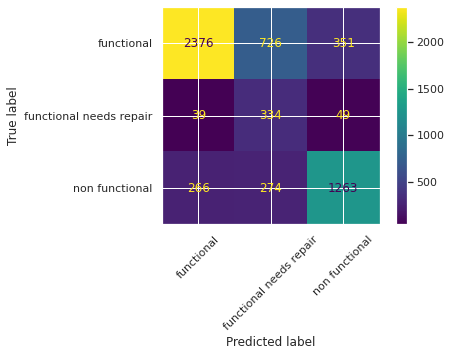

In [249]:

conf_matrix = plot_confusion_matrix(grid2.best_estimator_, df_dict['X_test_data_all'], df_dict['y_test_data_all'])
plt.grid('off')
plt.xticks(rotation=45)

In [254]:
# Finding feature importances for our logistic regression (the long way)

coefs = grid2.best_estimator_.named_steps['logreg'].coef_[0]
# cvals = coefs = grid4.best_estimator_.named_steps['logreg'].coef_
# classes = grid4.best_estimator_.named_steps['logreg'].classes_
weights = grid2.best_estimator_.named_steps['logreg'].intercept_
nfeat = grid2.best_estimator_.named_steps['logreg'].n_features_in_
feat_imp = pd.concat([pd.DataFrame(df_dict['X_train_data_all'].columns),pd.DataFrame(np.transpose(coefs))], axis = 1, names=['feature', 'coef'])
imp2 = pd.DataFrame(zip(df_dict['X_train_data_all'].columns, np.transpose(grid4.best_estimator_.named_steps['logreg'].coef_.tolist()[0])), columns=['features', 'coef'])

# feats = dict(zip(classes, coefs)) # doesn' work, classes_ only shows y
# coefs[:70]
# feats
# nfeat
# grid4.best_estimator_.named_steps['logreg'].n_iter_
# cvals

imp2['coef'] = imp2['coef'].map(abs)

imp2.sort_values('coef', ascending=False)

,features,coef
17,waterpoint_type_group,1.497198
15,quantity,1.259510
7,scheme_management,0.644359
4,basin,0.488439
6,population,0.460228
12,management,0.436565
3,installer,0.435325
9,permit,0.397621
11,extraction_type_class,0.373370
5,region,0.364512


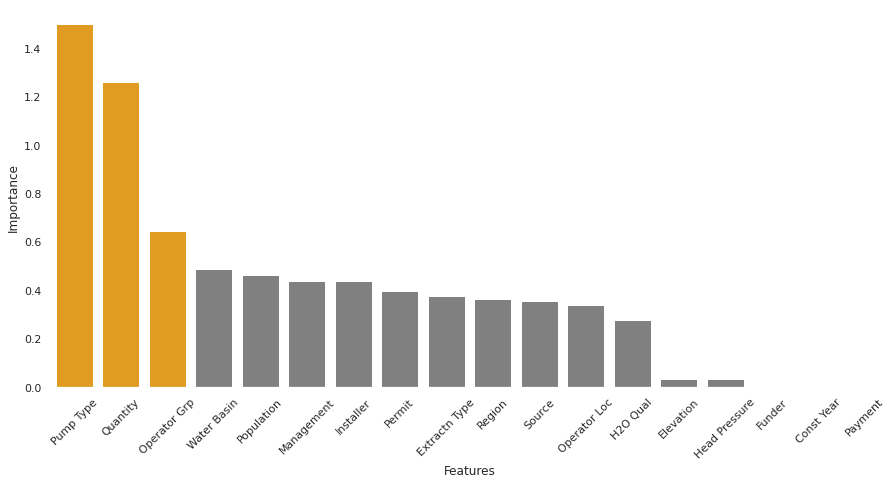

In [255]:
# Feature importances plot
fig, ax = plt.subplots(figsize=(15, 7))
pal = ['orange', 'orange', 'orange', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 
       'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']

plt.xticks(rotation=45)

sns.barplot(data=imp2.sort_values('coef', ascending=False), x='features', y='coef',
            palette=pal, dodge=False)
ax.set_ylabel('Importance')
ax.set_xlabel('Features')
ax.set_xticklabels(['Pump Type','Quantity','Operator Grp','Water Basin','Population',
                    'Management', 'Installer', 'Permit', 'Extractn Type', 'Region',
                    'Source', 'Operator Loc', 'H2O Qual', 'Elevation','Head Pressure',
                    'Funder', 'Const Year', 'Payment'])
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
